# CNN Histopathologic Cancer Detection Project (Final Report)

[LINK TO PROJECT REPO](https://github.com/rpforrest1/CNN_Cancer_Detection_Project/tree/main)

## Introduction

This project was created as a late submission for the Histopathologic Cancer Detection Kaggle competition here: [Kaggle Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection). The purpose of the project is to create an algorithm that will detect metastatic cancer in histopathologic scans of lymph node sections. The data provided in this competition was derived from a PatchCamelyon benchmark dataset here: [PCAM Github](https://github.com/basveeling/pcam).

In this project, I intend to build a CNN model that will perform binary classification of tif images (tumor vs non-tumor). Due to how the images were originally labeled, a positive label indicates that the center 32 x 32px region of a patch contains at least one pixel of tumor tissue.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import json
from models.model_helper_functions import plot_metric, plot_learning_rate
from models.data_pipeline import predict_on_kaggle_test_set
import tensorflow as tf

In [2]:
# If the kaggle submission file was already created, set to False.
CREATE_SUBMISSION_FILE = False

The initial overall file structure has a folder for training and testing images. A csv file is provided that maps training labels to the id, which is the image file name. I'll do a quick check to make sure the table contains no null values. 

In [3]:
data_dir = './data'
df = pd.read_csv(f'{data_dir}/train_labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
df['path'] = f'{data_dir}/train/' + df['id'] + '.tif'
print('Example of the modified train_labels csv file.')
display(df.head())

Example of the modified train_labels csv file.


,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,./data/train/f38a6374c348f90b587e046aac6079959...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,./data/train/c18f2d887b7ae4f6742ee445113fa1aef...
2,755db6279dae599ebb4d39a9123cce439965282d,0,./data/train/755db6279dae599ebb4d39a9123cce439...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,./data/train/bc3f0c64fb968ff4a8bd33af6971ecae7...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,./data/train/068aba587a4950175d04c680d38943fd4...


In [5]:
print(f'This dataset contains a total of {len(df)} tif images.')

example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print(f'The images are {image_shape[0]} x {image_shape[1]} with {image_shape[2]} color channels.')

This dataset contains a total of 220025 tif images.
The images are 96 x 96 with 3 color channels.


---

## Exploratory Data Analysis

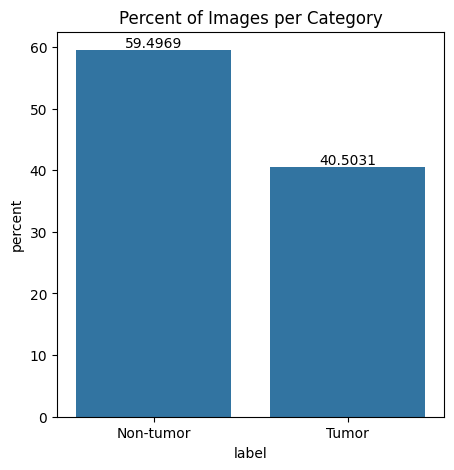

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
_ = sns.countplot(df, x='label', ax=ax, stat='percent', formatter=(lambda x: 'Tumor' if x else 'Non-tumor'))
plt.title('Percent of Images per Category')
plt.bar_label(ax.containers[0])
plt.show()

From the chart above, we can see that there is some imbalance in the dataset, with the majority of the labels being non-tumor. Due to this, I will alter my training strategy to account for the imbalance.

Since there is a large amount of data, I untimately intend to use all of it to create a training, validation, and test sets. I believe this data is large enough that I will not need to do any data augmentation such as flipping, rotating, shearing, etc.. Due to the size, I will also not attempt transfering weights from a pre-trained model.

In [7]:
def plot_examples(label:int,num_examples=8):
    """
    Plots example images.

    Args:
        label: Will be either a 0 (for non-tumor) or a 1 (for tumor)
        num_examples: The number of examples to plot
    """
    example_set = df[df['label'] == label]
    plt.figure(figsize=(num_examples-1, num_examples-1))
    for i in range(num_examples):
        ax = plt.subplot(int(num_examples/2), int(num_examples/2), i + 1)
        plt.imshow(Image.open(example_set.iloc[i]['path']))
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.axis("off")

Example of tumor images.


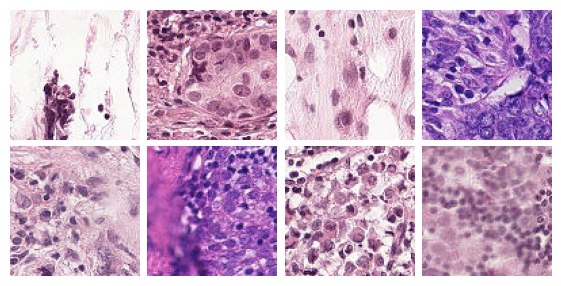

In [8]:
print('Example of tumor images.')
plot_examples(1)

Example of non-tumor images.


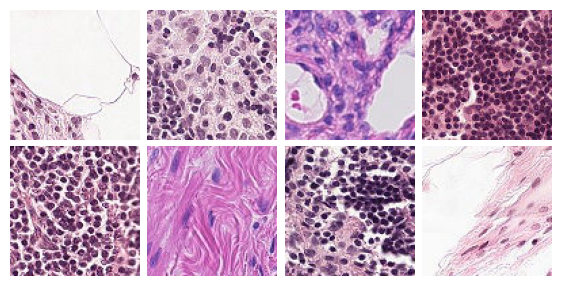

In [9]:
print('Example of non-tumor images.')
plot_examples(0)

When looking at some sample images, I do not have the experience to say what to look for as far as outliers are concerned. I would expect that any outliers would be images that didn't look like it came from a lymph node section. In these cases, I would expect the labeler and the model to assign these images to the negative class by default.

---

## Model Architecture and Tuning

For the model architecture, I will take most of my inspiration from VGGNet due to its simplicity. I will use a \[Convolution -> Convolution -> Max Pool] x Depth approach. I am interested in learning how many of these convolution segments are needed to get good results. I will do hyperparameter tuning in order to find the best parameters. For this first round of testing, I will compare a small dataset with the full dataset and based on the performance in the test set, I will choose that fastest model for further calibration.

**More details on the 6 models shown here are provided in the notebooks from this repo [Individual Model Notebook Link](https://github.com/rpforrest1/CNN_Cancer_Detection_Project/tree/main/models/trained_nbs)**. Since training takes a while, I wanted to see if I can use just half the dataset for more hyperparameter tuning later on. So models 1-3 will use half the data and models 4-6 will use the full dataset. I also wanted to get an understanding for how deep the network should be. For models 1 and 4, there is only 1 segment of \[Convolution -> Convolution -> Max Pool]. Models 2 and 5 use 3 of these segments. Models 3 and 6 will use 5 of these segments. Based on the number of segments, the filter counts will increase accordingly, with the models using 5 segments having filter counts as such: 32, 64, 128, 256, and 512.

Everything else between the model test will remain the same since I believe it will provide a solid bases for comparison. Adam as the optimizer, Batch size of 32, 3x3 filter size, 2x2 pooling size, batch normalization used throughout, early stopping with a patience of 3, reducing learning rate with a patience of 1, initial learning rate of 0.0001, max epochs of 15, and the classifier portion of the network will be 1 dense layer with 256 units with Sigmoid activation function.

In [10]:
def load_model_data(first_model_num:int, last_model_num:int):
    """
    Loads multiple results from tensorflow model runs.

    Args:
        first_model_num: The first model number to load.
        last_model_num: The last model number to load.
    """

    model_histories = []
    model_metrics = []
    for i in range(first_model_num, last_model_num+1):
        _mdl_df = pd.read_json(f'./models/model_checkpoints/model{i}/model_history.json')
        total_time = _mdl_df['total_time'].max()
        _mdl_df.drop('total_time', axis=1, inplace=True)
        model_histories.append(_mdl_df)
        
        _mdl_df2 = pd.DataFrame(json.load(open(f'./models/model_checkpoints/model{i}/test_metrics.json')), index=[f'model{i}'])
        _mdl_df2['model_training_time'] = total_time
        model_metrics.append(_mdl_df2)
    
    return model_histories, pd.concat(model_metrics)

In [11]:
model_histories, model_metrics = load_model_data(1,6)

In [12]:
print('Models 1-6 test set metrics')
display(model_metrics)

Models 1-6 test set metrics


,loss,accuracy,auc,model_training_time
model1,0.378731,0.837717,0.905563,265.452751
model2,0.210391,0.916495,0.971591,444.668267
model3,0.305652,0.881227,0.944572,250.445711
model4,0.337856,0.856442,0.925481,459.640423
model5,0.169443,0.934493,0.980816,961.022362
model6,0.170110,0.935947,0.980205,1367.978276


For the test set data, we can see that the top 3 models (based on AUC) are model2, model5 and model6. Model2 stands out as the most interesting since its trained with only half the data, and is getting very similar performance to the other 2 models. The added benefit of model2 is that the total training time is half the amount of the others. I may rule out model6 from further consideration since the added complexity appears to be unneeded compared to model2 and model5. I will see how further tuning goes before making a final decision.

Lets take a closer look on how the training went for model2.

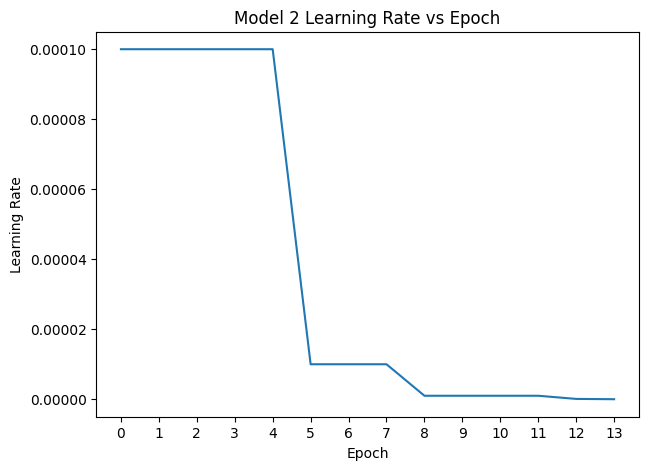

In [13]:
plot_learning_rate(model_histories[1], 2)

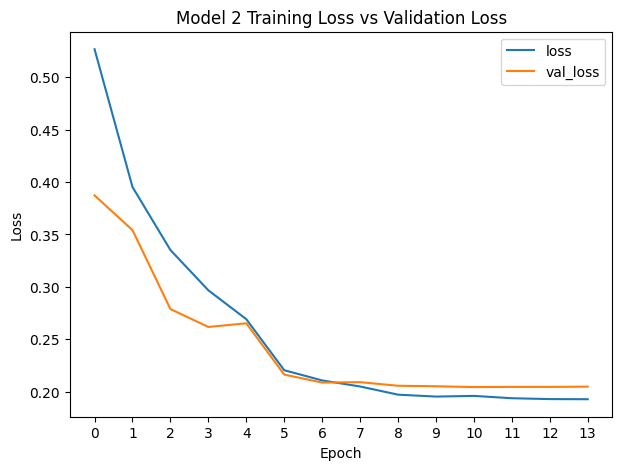

In [14]:
plot_metric(model_histories[1], 'loss', 2)

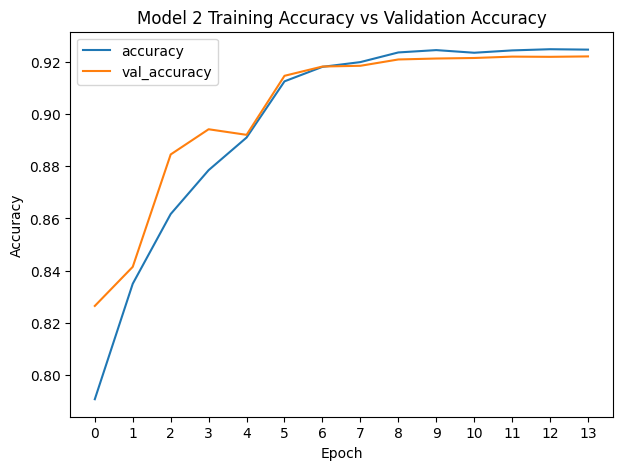

In [15]:
plot_metric(model_histories[1], 'accuracy', 2)

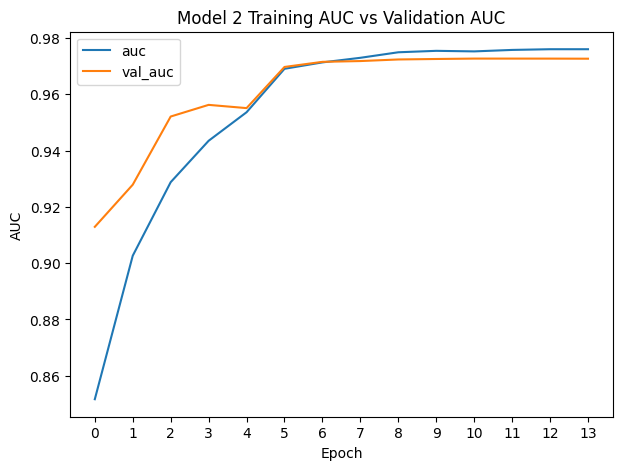

In [16]:
plot_metric(model_histories[1], 'auc', 2)

Overall the results look pretty good and I see no signs of over or underfitting. As another spot check, I'll use model2 to predict the score for the kaggle test set and report the result.

In [17]:
if CREATE_SUBMISSION_FILE:
    model2 = tf.keras.models.load_model('./models/model_checkpoints/model2/cp.ckpt')
    model2_submission = predict_on_kaggle_test_set(f'{data_dir}/test/', batch_size=32, model=model2)
    model2_submission.to_csv('model2_submission.csv', index=False)
else:
    print('Submission file already created for model2.')

Submission file already created for model2.


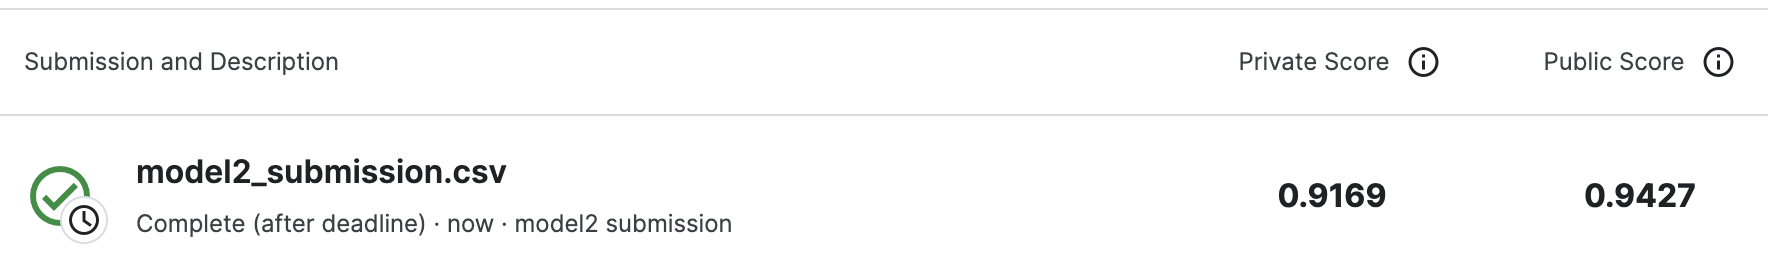

The private and public score for model2 are pretty high with both being above 0.90. I feel good about using this model as my baseline for now. To conduct further hyperparameter tuning, I will take model2 and do more iterations since the training time is quick and still has good performance. If any altered parameters lead to a higher performance, I will consider including that change into the final model.

**The link to these notebooks are in the same location here: [Individual Model Notebook Link](https://github.com/rpforrest1/CNN_Cancer_Detection_Project/tree/main/models/trained_nbs)**

I will test out these changes to model2:
- model7: Batch size of 64
- model8: Filter sizes in final segment of 5x5
- model9: 1 extra dense layer in the classifier portion of the model (128 units)
- model10: Rmsprop for the optimization.
- model11: Leaky Relu instead of Relu for all activations

In [18]:
model_histories_2, model_metrics_2 = load_model_data(7,11)

In [19]:
print('Models 7-11 test set metrics')
display(model_metrics_2)

Models 7-11 test set metrics


,loss,accuracy,auc,model_training_time
model7,0.262972,0.889347,0.955929,474.060606
model8,0.222553,0.908738,0.968369,338.636938
model9,0.242270,0.896497,0.962401,382.283604
model10,0.233365,0.906920,0.965037,528.387810
model11,0.226434,0.906436,0.967217,499.705829


After reviewing the results, none of the altered hyperparameters look appealing for consideration into the final model. All of the AUC values are close to the test baseline model2, suggesting that using the tested hyerparameter will not meaningfully change the result. This will conclude all of the hyperparameter tuning that I will attempt.

---

## Final Results

Ultimately it looks like the model architecture itself is the most important criteria to consider that determines performance (in this case) and second most important being the amount of data used for training. I believe the initial decisions made for the models provided a solid bases for further tuning. Those decisions being batch normalization and early stopping to reduce overfitting. Automatically having the learning rate reduce helps the model converge in all cases tested. I'll go over some reasons why I believe my 2nd round of testing, didn't produce any meaningful results **notes are in bold**.

- model7: Batch size of 64 => **A larger batch size will reduce the number of weight updates. It may work better if the max epoch increased.**
- model8: Filter sizes in final segment of 5x5 => **A 5x5 filter may not be enough to test. Having more 5x5 wouldn't be as efficient as 3x3s**
- model9: 1 extra dense layer in the classifier portion of the model (128 units) => **The classifier portion of the architecture must not be the weak point. Feature extraction plays the main role.**
- model10: Rmsprop for the optimization. => **The Adam optimizer and Rmsprop must not be all that different for this dataset.**
- model11: Leaky Relu instead of Relu for all activations => **The Leaky Relu and Relu may not show a difference due to the batch normalization being done.**

Since model2 was already looked at earlier, I will show the results for model5 and model6, including the kaggle score.

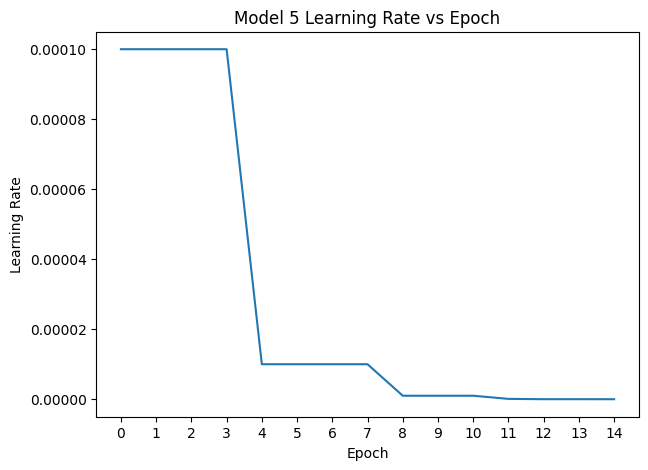

In [20]:
plot_learning_rate(model_histories[4], 5)

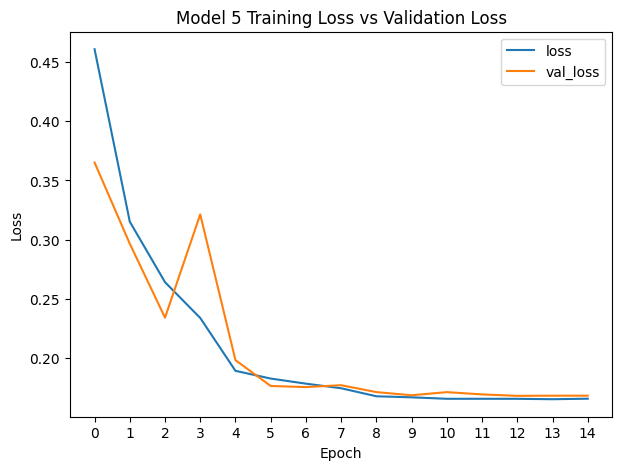

In [21]:
plot_metric(model_histories[4], 'loss', 5)

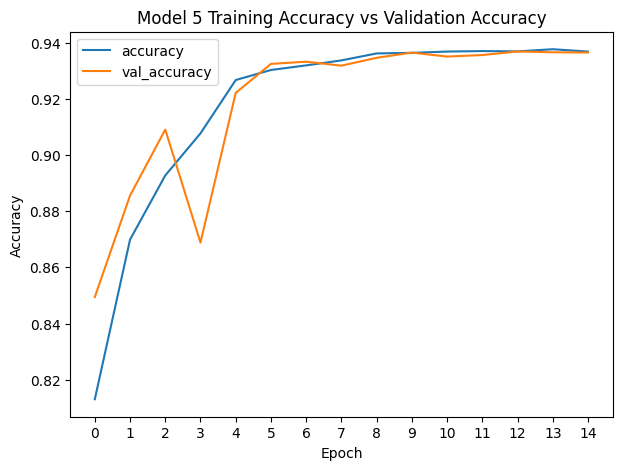

In [22]:
plot_metric(model_histories[4], 'accuracy', 5)

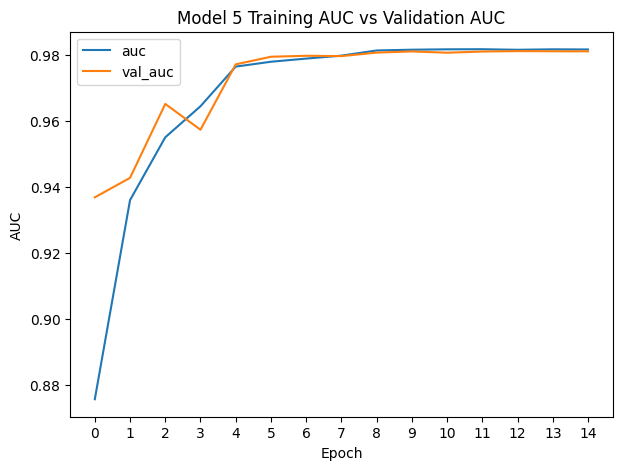

In [23]:
plot_metric(model_histories[4], 'auc', 5)

When looking at the graphs, its interesting to see how the automatic learning rate reduction really helped the model with converging.

In [24]:
if CREATE_SUBMISSION_FILE:
    model5 = tf.keras.models.load_model('./models/model_checkpoints/model5/cp.ckpt')
    model5_submission = predict_on_kaggle_test_set(f'{data_dir}/test/', batch_size=32, model=model5)
    model5_submission.to_csv('model5_submission.csv', index=False)
else:
    print('Submission file already created for model5.')

Submission file already created for model5.


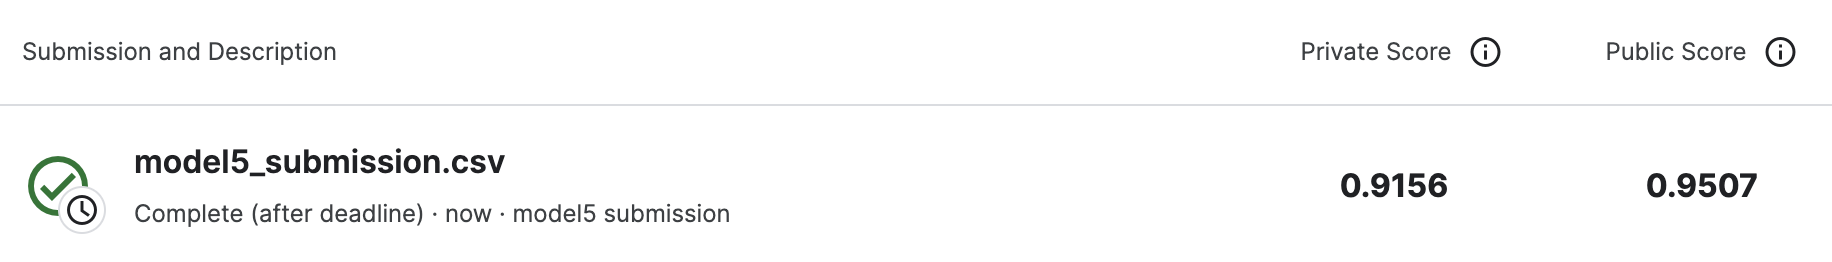

Just to restate, the architecture for model2 and model5 are the same, except model5 utilized all of the data for the training pipeline. The private score for model2 was 0.9169 and public score was 0.9427. Overall model5 performed slightly better if looking at the total score increase.

Now lets take a look at how model6 performed.

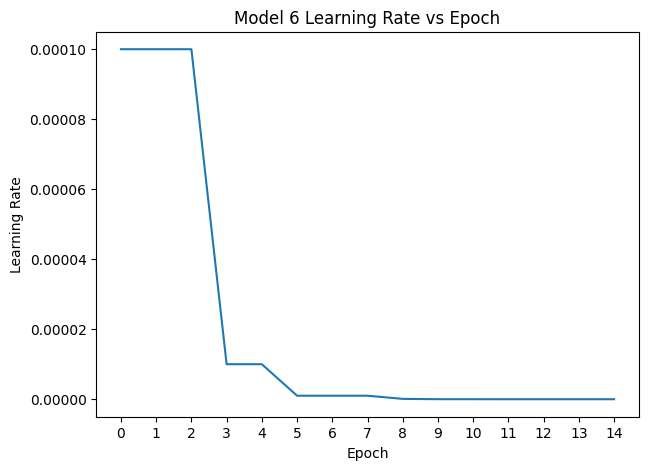

In [25]:
plot_learning_rate(model_histories[5], 6)

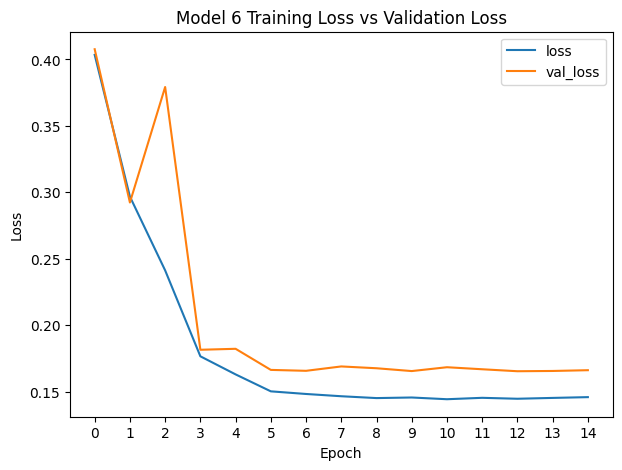

In [26]:
plot_metric(model_histories[5], 'loss', 6)

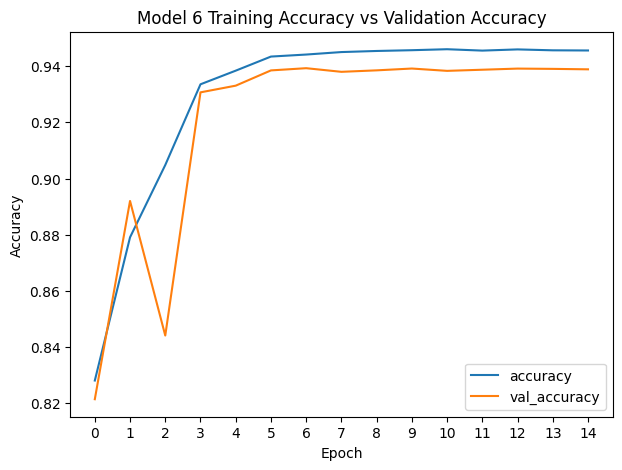

In [27]:
plot_metric(model_histories[5], 'accuracy', 6)

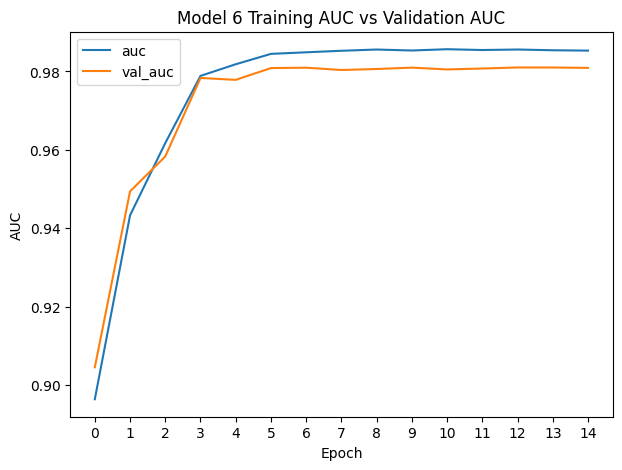

In [28]:
plot_metric(model_histories[5], 'auc', 6)

The learning rate reduction helped model6 similarly to model5. The AUC wasn't as affected by spike in the validation loss.

In [29]:
if CREATE_SUBMISSION_FILE:
    model6 = tf.keras.models.load_model('./models/model_checkpoints/model6/cp.ckpt')
    model6_submission = predict_on_kaggle_test_set(f'{data_dir}/test/', batch_size=32, model=model6)
    model6_submission.to_csv('model6_submission.csv', index=False)
else:
    print('Submission file already created for model6.')

Submission file already created for model6.


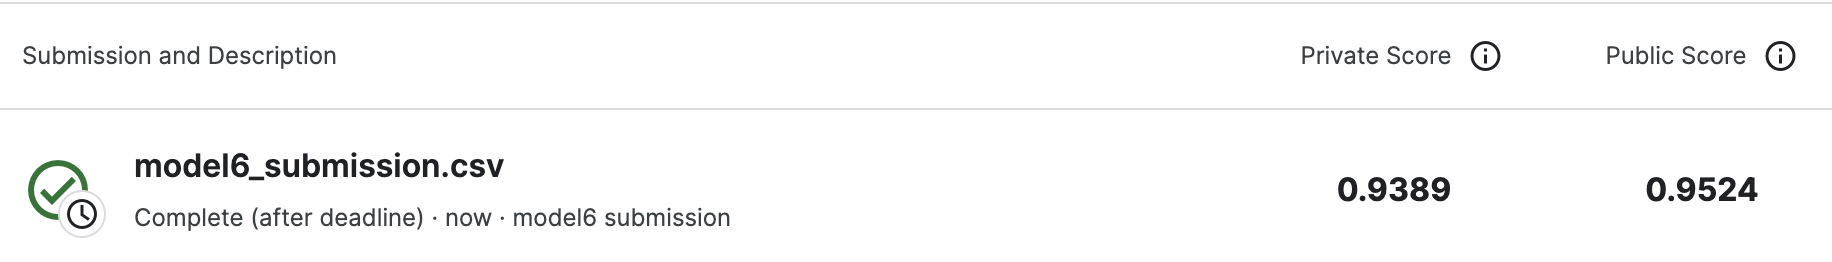

The score for model6 is a little better than model2 and model5. The architecture for model6 is deeper since its using 5 \[Convolution -> Convolution -> Max Pool] segments. It also uses the entire training dataset just like model5.

The models I would recommend for this task would either be model2 or model6. Model2 is good if wanting a faster model to train, but results may vary since the half data that was used, my include some luck in getting good examples. Model6 would be more robust since it uses all the available data. In order to get a better performing model, I believe making the model deeper and adding additional augmented data would lead to some increase in performance.

---

## Conclusion

Overall I believe taking inspiration from VGGNet and creating a simple \[Convolution -> Convolution -> Max Pool] x Depth architecture was a good idea. There are more efficient architectures out there, but this one proved to get the task done pretty well. Including critical components into the model that reduces overfitting like batch normalization and early stopping was important in order to do proper testing across many hyperparameters. Having the learning rate reduce was also critical in getting the models to converge. Since the baseline performance was already good, the tuning I did in round 2 didn't contribute much new information. Changing the optimizer for example, may only be beneficial if the model was initially having issues converging. I believe a method of getting a better performing model (that may result in overfitting) would be to increase the data through data augmentation and to increase the depth of the model. Tweeking the architecture to something like InceptionNet or ResNet could also prove beneficial but I am unsure by how much.

---